<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Базовые-модели" data-toc-modified-id="Базовые-модели-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Базовые модели</a></span></li><li><span><a href="#Bert-from-paper" data-toc-modified-id="Bert-from-paper-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Bert from paper</a></span></li><li><span><a href="#Model-config" data-toc-modified-id="Model-config-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Model config</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» c  BERT



Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
# !pip install torch
# !pip install torchmetrics

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet 
from nltk.corpus import stopwords
import re 


import os
from tqdm import notebook 

import torch
from transformers import BertTokenizer, BertModel
import transformers

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

SEED = 41
MODEL_NAME = 'distilbert-base-uncased'
torch.manual_seed(SEED)

[nltk_data] Downloading package stopwords to /Users/ac1d/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ac1d/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/ac1d/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:

def evaluate_and_report(report_df:pd.DataFrame, 
                        model, X, y, 
                        model_name, scoring='f1', 
                        predict_proba=False, 
                        thresh=0.3):
    '''
    Function to evaluate model and make report Dataframe
    '''
    
    report = pd.DataFrame()
    report.index = [model_name]
    if predict_proba:
        predicted = (model.predict_proba(X)[:,1] >= thresh).astype(int)
        report['f1'] = f1_score(y, predicted)
                       
                       
    else:
        predicted = model.predict(X)
        cv_marks = cross_val_score(model, X, y, scoring=scoring, cv=5, n_jobs=-1)
        print(f"cross_vall_score: {cv_marks}")
        report['f1'] = cv_marks.mean()
    
    
    
    report.loc[:,'precision_0'] = precision_score(
        y, predicted, pos_label=0)
    report.loc[:,'precision_1'] = precision_score(
        y, predicted, pos_label=1)
    report.loc[:,'recall_0'] = recall_score(
        y, predicted, pos_label=0)
    report.loc[:,'recall_1'] = recall_score(
        y, predicted, pos_label=1)
    
    
    report_df = report_df.append(report)
    return report_df

## Подготовка

In [2]:
local_path = '../datasets/toxic_comments.csv'
cloud_path = '/datasets/toxic_comments.csv'

if os.path.exists(local_path):
    df = pd.read_csv(local_path)
elif os.path.exists(cloud_path):
    df = pd.read_csv(cloud_path)
else:
    print('something wrong! Check path')

In [3]:
df

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


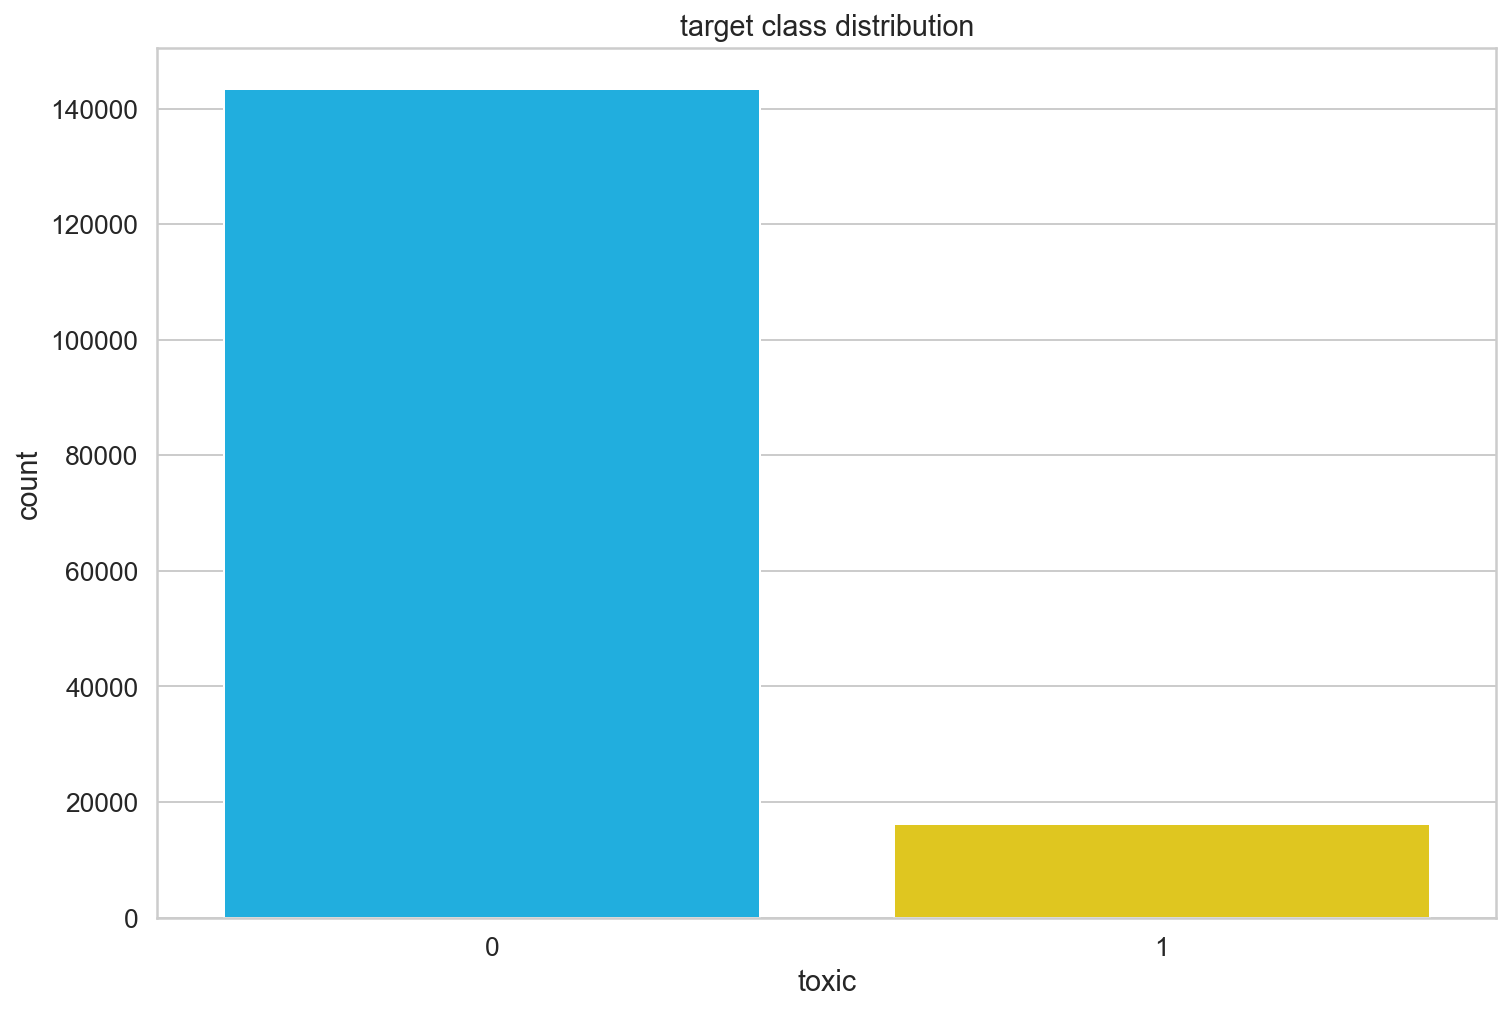

In [6]:
sns.countplot(data=df, x='toxic')
plt.title('target class distribution');

In [4]:
m = WordNetLemmatizer()
cleared = []

for i in notebook.tqdm(range(df.shape[0])):
    text = re.sub(r'[^a-zA-Z]', ' ', df['text'][i])
    text = m.lemmatize(text)
    text = ''.join(text)
    cleared.append(text)
df['lemmatize'] = cleared
df['lemmatize'][0]

  0%|          | 0/159571 [00:00<?, ?it/s]

'Explanation Why the edits made under my username Hardcore Metallica Fan were reverted  They weren t vandalisms  just closure on some GAs after I voted at New York Dolls FAC  And please don t remove the template from the talk page since I m retired now             '

In [8]:
# def lemmatize(text):
#     m = WordNetLemmatizer()
#     lemm_list = m.lemmatize(text)
#     lemm_text = "".join(lemm_list)
        
#     return lemm_text


# def clear_text(text):
#     text = re.sub(r'[^a-zA-Z ]', ' ', text)
#     text = " ".join(text.split())
#     return text


In [9]:
stop_words = set(stopwords.words('russian'))
tfidf_vect = TfidfVectorizer(stop_words=stop_words)
    
transformed = tfidf_vect.fit_transform(df['lemmatize'])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(transformed, df.toxic,
                                                   test_size=.3)

## Обучение

### Базовые модели

In [11]:
# Baseline - logreg
logreg_model = LogisticRegression()

logreg_model.fit(X_train, y_train)

report_df = pd.DataFrame()
report_df = evaluate_and_report(report_df, logreg_model, X_test, y_test, 'logreg')
report_df

cross_vall_score: [0.61663286 0.63186078 0.63920266 0.64379947 0.66227781]


,f1,precision_0,precision_1,recall_0,recall_1
logreg,0.638755,0.954106,0.92798,0.994733,0.586506


In [12]:
# Random forest
rf_model = RandomForestClassifier(random_state=SEED, 
                                  n_estimators=50,
                                  n_jobs=-1,
                                 verbose=10)

rf_model.fit(X_train, y_train)

report_df = evaluate_and_report(report_df, rf_model, X_test, y_test, 'random_forest')
report_df

building tree 1 of 50building tree 2 of 50

building tree 3 of 50
building tree 4 of 50building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 9 of 50
building tree 10 of 50


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s


building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.8s


building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   15.6s


building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   30.4s


building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.1s


building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   44.9s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   45.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   50.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  41 out of  50 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  47 out of  50 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent

cross_vall_score: [0.45616642 0.46026987 0.44804716 0.51603706 0.481615  ]


[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   48.3s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   50.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  41 out of  50 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  47 out of  50 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   50.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]:

,f1,precision_0,precision_1,recall_0,recall_1
logreg,0.638755,0.954106,0.927980,0.994733,0.586506
random_forest,0.472427,0.933071,0.966292,0.998462,0.381067


In [13]:
# lightGBM

lgb_model = LGBMClassifier(random_state=SEED)

lgb_model.fit(X_train, y_train)

LGBMClassifier(random_state=41)

In [14]:
report_df = evaluate_and_report(report_df, lgb_model, X_test, y_test, 'lightgbm')
report_df

cross_vall_score: [0.71931956 0.72738386 0.71804281 0.73989137 0.7346691 ]


,f1,precision_0,precision_1,recall_0,recall_1
logreg,0.638755,0.954106,0.927980,0.994733,0.586506
random_forest,0.472427,0.933071,0.966292,0.998462,0.381067
lightgbm,0.727861,0.958756,0.913386,0.993078,0.630816


In [15]:
report_df = evaluate_and_report(report_df, lgb_model, X_test, y_test, 'lightgbm_thresh_0.3', predict_proba=True)
report_df

,f1,precision_0,precision_1,recall_0,recall_1
logreg,0.638755,0.954106,0.927980,0.994733,0.586506
random_forest,0.472427,0.933071,0.966292,0.998462,0.381067
lightgbm,0.727861,0.958756,0.913386,0.993078,0.630816
lightgbm_thresh_0.3,0.770267,0.967434,0.836441,0.983849,0.713797


### Bert from paper

In [19]:
!pip install torch torchmetrics transformers wandb

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [20]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score


# WandB – Import the wandb library
import wandb
# WandB – Initialize a new run
wandb.login()
wandb.init(project="toxic_comment_detection")
wandb.watch_called = False
from tqdm import notebook 

import torch
from transformers import AutoTokenizer, BertModel
import transformers

# from google.colab import drive
# drive.mount('/content/drive')

PATH = Path('drive/MyDrive/Colab_Notebooks/')

wandb: Currently logged in as: ac1d. Use `wandb login --relogin` to force relogin


In [21]:
local_path = '../datasets/toxic_comments.csv'
cloud_path = '/datasets/toxic_comments.csv'
colab_path = Path(PATH / 'datasets/toxic_comments.csv')

if os.path.exists(local_path):
    df = pd.read_csv(local_path)
elif os.path.exists(cloud_path):
    df = pd.read_csv(cloud_path)
elif os.path.exists(colab_path):
    df = pd.read_csv(colab_path)
else:
    print('something wrong! Check path')

### Model config

In [22]:
DATA_SIZE = 1000 #int(len(df) * .2) # num of objects hand over pytorch. if whole dataset - len(df)
MODEL_NAME = 'bert-base-cased' # parameter for download pretrained model and tokenizer
MAX_LENGTH = 400
BATCH_SIZE = 8
LEARNING_RATE = 3e-5 

In [23]:
# original paper text:
# https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [24]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [25]:
df = df.sample(DATA_SIZE)
sentences = df.text.values
labels = df.toxic.values

In [26]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  "

 LISa 2 

Man this page is empty ah well left cleand up some of the artical but i really need that you whacth it when you have time. the rookie "
Tokenized:  ['"', 'lisa', '2', 'man', 'this', 'page', 'is', 'empty', 'ah', 'well', 'left', 'clean', '##d', 'up', 'some', 'of', 'the', 'art', '##ical', 'but', 'i', 'really', 'need', 'that', 'you', 'w', '##ha', '##ct', '##h', 'it', 'when', 'you', 'have', 'time', '.', 'the', 'rookie', '"']
Token IDs:  [1000, 7059, 1016, 2158, 2023, 3931, 2003, 4064, 6289, 2092, 2187, 4550, 2094, 2039, 2070, 1997, 1996, 2396, 7476, 2021, 1045, 2428, 2342, 2008, 2017, 1059, 3270, 6593, 2232, 2009, 2043, 2017, 2031, 2051, 1012, 1996, 8305, 1000]


In [27]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  "

 LISa 2 

Man this page is empty ah well left cleand up some of the artical but i really need that you whacth it when you have time. the rookie "
Tokenized:  ['"', 'lisa', '2', 'man', 'this', 'page', 'is', 'empty', 'ah', 'well', 'left', 'clean', '##d', 'up', 'some', 'of', 'the', 'art', '##ical', 'but', 'i', 'really', 'need', 'that', 'you', 'w', '##ha', '##ct', '##h', 'it', 'when', 'you', 'have', 'time', '.', 'the', 'rookie', '"']
Token IDs:  [1000, 7059, 1016, 2158, 2023, 3931, 2003, 4064, 6289, 2092, 2187, 4550, 2094, 2039, 2070, 1997, 1996, 2396, 7476, 2021, 1045, 2428, 2342, 2008, 2017, 1059, 3270, 6593, 2232, 2009, 2043, 2017, 2031, 2051, 1012, 1996, 8305, 1000]


In [28]:
# Tokenize all of the sentences and map the tokens to thier word IDs.


input_ids = []
attention_masks = []


# For every sentence...
for i, sent in enumerate(notebook.tqdm(sentences)):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])


  0%|          | 0/1000 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  "

 LISa 2 

Man this page is empty ah well left cleand up some of the artical but i really need that you whacth it when you have time. the rookie "
Token IDs: tensor([ 101, 1000, 7059, 1016, 2158, 2023, 3931, 2003, 4064, 6289, 2092, 2187,
        4550, 2094, 2039, 2070, 1997, 1996, 2396, 7476, 2021, 1045, 2428, 2342,
        2008, 2017, 1059, 3270, 6593, 2232, 2009, 2043, 2017, 2031, 2051, 1012,
        1996, 8305, 1000,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    

In [29]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 75-25 train-validation split.

# Calculate the number of samples to include in each set.

train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size
test_size = val_size // 2


# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


val_dataset, test_dataset = random_split(val_dataset, [test_size,
                                                       (test_size + 1 if val_size % 2 else test_size)]) # check is even number

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))


  750 training samples
  250 validation samples


In [30]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
# batch_size = 32 

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = BATCH_SIZE # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
        )
test_dataloader = DataLoader(
    test_dataset,
    sampler = SequentialSampler(test_dataset),
    batch_size = BATCH_SIZE
)

In [31]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
# model.cuda()
device = ('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

cpu


In [32]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    !nvidia-smi
else:
    print('!!! TRAINING ON CPU !!! ')

!!! TRAINING ON CPU !!! 


In [33]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [34]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = LEARNING_RATE, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [35]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [36]:
import numpy as np
# from torchmetrics import F1Score
from sklearn.metrics import f1_score

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy_f1(preds, labels, num_classes=2):
    metrics_dict = {}
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    # f1 = F1Score(num_classes)
    # f1_value = f1(torch.from_numpy(preds),
                  # torch.from_numpy(labels))
    metrics_dict['accuracy'] =  np.sum(pred_flat == labels_flat) / len(labels_flat)
    metrics_dict['f1'] = f1_score(labels, np.where(preds[:,0] < 0.5, 0, 1))
    # return np.sum(pred_flat == labels_flat) / len(labels_flat)
    return metrics_dict

In [37]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [38]:
import random



# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(notebook.tqdm(train_dataloader)):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels,
                            return_dict=False)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
#         print(loss)
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_f1 = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for i, batch in enumerate(notebook.tqdm(validation_dataloader)):
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels,
                                  return_dict=False)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        metrics_dict = flat_accuracy_f1(logits, label_ids)
        total_eval_accuracy += metrics_dict['accuracy']
        total_eval_f1 += metrics_dict['f1']



    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)

    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    print(f"   F1-score: {metrics_dict['f1']:.2f}")
    print(metrics_dict)
    # Wandb
    wandb.log({
        "Train loss": avg_train_loss,
        "Valid loss": loss.item(),
        "Valid Accuracy": metrics_dict['accuracy'],
        "Valid F1": metrics_dict['f1']
        })


    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...


  0%|          | 0/94 [00:00<?, ?it/s]

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

KeyboardInterrupt: 

## Выводы

- Наш датасет имеет дисбаланс классов, токсичных комментариев значительно меньше обычных.
- хорошо видно, что именно полнота класса 1 имеет низкие значения, что вносит свой вклад в низкую оценку f1.
- Для нашей задачи не страшно, если мы неправильно пометим нетоксичные комментарии в небольших количествах случаев (False Positive)
поэтому для борьбы с дисбалансом классов принято решение изменить порог логистической регрессии с 0.5 до 0.3. 
- Результат по прохождению необходимого порога метрики F1 достигнут. 

**Bert**
- В примере из Notion, как мне кажется, есть ошибка. Там обявляется модель:
odel = transformers.BertModel.from_pretrained('rubert_model.bin', config=config)
- Затем все разбиывается на бачи, признаки и таргеты а затем:
model.fit(train_features, train_target)
Насколько я понимаю, этот пример скопипастили из статьи на Хабре - https://habr.com/ru/post/498144/
Однако в примере из статьи в качестве последнего слоя используют логистическую регрессию из sklearn, которую можно так обучать, а в нашем случае к такой модели применить fit() predict() не получится. Прошу связаться по этому поводу с авторами курса, или опровергнуть мою гипотезу. 

- Запустить bert удалось только с помощью огромной простыни выше. Долго пытался запустить с помощью catalyst, создавал датасеты, даталоадеры, упаковывал всё в словари, но получал ошибку **KeyError: 'Indexing with integers (to access backend Encoding for a given batch index) is not available when using Python based tokenizers' site:stackoverflow.com**
В гугле способ решения не нашёл.

-  Мне удалось запустить BERT на GPU в google colab. Для отладки кода я использовал размер выборки 1000 с разделением на трэйн и валидацию. На этом этапе были фантастические метрики по accuracy и f1(0.96), настораживает, правда, что они в точности совпадали по значениям. 
![title](colab.png)

- На выборке ~10% от датасета на двух эпохах, с метриками произошла какая-то беда. Лосс стал возрастать, f1 и accuracy ниже разумного порога. 
- К сожалению colab выкинул меня из gpu из-за ограничений на время выполнения, поэтому для однозначных выводов у меня сейчас нет ресурсов. Однако, думаю, что если применить fine-tuning(обновить весов последнего слоя), можно добиться очень хороших результатов. 

- Обучение на локальном компьютере прервал, т.к. нет времени ждать. Позже продолжу эксперименты в google colab. 


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны